[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/xgb-integration-py-reg/xgb-integration-py-reg.ipynb)

# Using SigOpt's XGBoost Integration for Regression

SigOpt's XGBoost integration does more than provide a streamlined SigOpt API for your XGBoost modeling. Read on to learn how the XGBoost integration helps find better performing models faster and simpler than ever before.

This walkthrough will provide an end-to-end example of utilizing the SigOpt XGBoost integration for a regression machine learning problem. For more information, please see our [XGBoost integration blog post announcement](https://sigopt.com/blog/live-now-new-xgboost-integration/), or the XGBoost integration [docs](https://docs.sigopt.com/xgboost/installation), including a tutorial on how to set up and start using SigOpt's XGBoost integration. We recommend that before you dive into this tutorial, [sign up](https://sigopt.com/signup) for a free SigOpt account so you can easily follow along and run the code yourself. 

## SigOpt's XGBoost Integration
[XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) is a popular machine learning framework for gradient-boosted trees known for its flexibility, portability, hardware optimizations, efficiency at scale, and general effectiveness for a wide variety of machine learning problems. We at SigOpt have made significant improvements to integrate [XGBoost's learning API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training) into SigOpt's Python API. 

Additionally, we have devoted significant research and development efforts to enhance SigOpt's efficiency and optimization for XGBoost. This includes model-aware optimization on top of SigOpt's standard hyperparameter optimization, utilizing metalearning and multi-fidelity optimization tailored for XGBoost. Using a variety of datasets, training parameters, and workloads to inform the Bayesian Optimization for XGBoost under the hood, this integration enables the SigOpt optimizer to automatically select the XGBoost hyperparameters and begins its search in hyperparameter value ranges most likely to improve the model's performance, optimizing in an informed fashion with no additional work required from the user. 

In internal testing with a variety of public datasets from small to large, models optimized through the XGBoost integration on average optimized 33% faster than the same XGBoost architectures optimized through vanilla SigOpt without loss of performance. These novel approaches also allow for simpler optimization without an in-depth understanding of XGBoost's 25+ hyperparameters and hyperparameter ranges.

To run this code yourself, you'll need the following:
* a SigOpt account (sign up free [here](https://app.sigopt.com/signup) with an email address)
* a Kaggle account to access the data
* the necessary packages installed in a Python 3 environment where you will run this code from

## Import Packages and Configure SigOpt API

First, ensure you have the SigOpt XGBoost integration installed. If you do not, uncomment the below code to install it.

In [1]:
#%pip install 'sigopt[xgboost]' #this will install numpy and xgboost as dependencies
import sigopt.xgboost

/Users/tskelton/demo/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The following will configure your SigOpt API connection from a .ipynb file. Your API token can be found [here](https://app.sigopt.com/tokens/info).

In [2]:
%load_ext sigopt
%sigopt config

SigOpt API token (find at https://app.sigopt.com/tokens/info): ········
Log Collection
	This will capture and upload the standard output and standard error of your
	Runs from the CLI and notebook cells so that you can view them on the SigOpt dashboard.
Enable log collection [y/N]: y
Notebook Cell Tracking
	This will record and upload the content of your notebook cells so that you can view them
	on the SigOpt dashboard.
Enable cell tracking [y/N]: y


Alternatively, and if you are not using an .ipynb file to run this code, uncomment the following code and set the environment variables with your SigOpt API token in order to connect to SigOpt.

In [3]:
#import os
#os.environ["SIGOPT_API_TOKEN"] = # PASTE API TOKEN FROM https://app.sigopt.com/tokens/info
#os.environ["SIGOPT_PROJECT"] = "my-xgb-integration-reg-project"

We'll import all other needed packages. If you do not have any of the libraries installed, you can uncomment the following to install the required packages.

In [3]:
#%pip install -r requirements.txt
%pip install opendatasets #needed for Colab or if the opendatasets package is not installed

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import xgboost as xgb
import opendatasets as od

random_no = 42

## Prepare Data

Our goal is to create and tune an XGBoost model using SigOpt to predict the amount of time a car with various features will take to pass testing during manufacturing. Our dataset comes from Mercedes-Benz's [Kaggle competition](https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/overview) from 2017. Let's download this data from Kaggle and take a look at it.

The following code block will download the competition's data .csv files into a new folder in the same directory as this notebook using the open source library [opendatasets](https://github.com/JovianML/opendatasets). You will need to provide your Kaggle username and API token, which can be found by accessing your Kaggle account page and clicking "Create new API Token." This will download a .json file which contains both your username and API token. If you receive an error message, ensure you have also accepted the Mercedes-Benz Greener Manufacturing Kaggle competition rules on the competition data page [here](https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing/data) while logged in to your Kaggle account.

Alternatively, you can manually download the files from the competition's data page into a folder called "mercedes-benz-greener-manufacturing" within the same directory as this notebook.

In [4]:
od.download("https://www.kaggle.com/competitions/mercedes-benz-greener-manufacturing")

Skipping, found downloaded files in "./mercedes-benz-greener-manufacturing" (use force=True to force download)


In [5]:
train = pd.read_csv("./mercedes-benz-greener-manufacturing/train.csv.zip")
train

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


This dataset includes 4,209 rows, one for each car, with over 300 anonymized features that represent different customizations and options for each car. Using this information we will train a model to predict the column `y`, which represents the time taken to pass testing process during manufacturing. The dataset is primarily categorical features (anonymized with letters) and binary features (coded as 0's and 1's).

We'll need to convert the non-numerical data into data our XGBoost model can understand. Let's utilize Scikit-Learn's `LabelEncoder` to convert the text data that into numerical categories.

In [6]:
for col in train.select_dtypes(include='object').columns:
    le = LabelEncoder()
    col_vals = list(train[col].astype(str).values)
    le.fit(col_vals)
    train[col] = le.transform(col_vals)

In the real world, we might perform feature engineering or other data processing techniques to further improve performance. However, for simplicity, we don’t make further changes to our data.

Now that we have our data ready, we'll split the data into a training, validation, and test set. We create a test set with 20% of the data, a validation set with 20% of the data, and use the remaining 60% of the data to train our model.

In [7]:
X = train.drop(['y', 'ID'], axis=1)
y = train['y']

#split data into a test and validation set of 20% of full data
(X_fulltrain, X_test, y_fulltrain, y_test) = train_test_split(X, y, test_size=0.2, random_state=random_no)
(X_train, X_val, y_train, y_val) = train_test_split(X_fulltrain, y_fulltrain, test_size=0.25, random_state=random_no)

dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
dval = xgb.DMatrix(data=X_val, label=y_val, feature_names=X_val.columns)
dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X_test.columns)

## Train Baseline Model

First we'll create and train a baseline XGBoost model with the default hyperparameter values as a simple point of comparison. Although we won't be tuning this model's hyperparameters, we can still use SigOpt for checkpointing, logging, and analyzing the results on SigOpt's web dashboard. Utilizing the `sigopt.xgboost.run` API is very similar to using `xgboost.train`.

In the `sigopt.xgboost.run` call we provide the parameters, the DMatrix with training data, and the run options. For the simple baseline we won't perform any hyperparameter tuning and will simply use the XGBoost library defaults. `sigopt.xgboost.run()` returns an XGBRun object, which we can use to retrieve the trained XGBoost Booster model itself with `.model` and the SigOpt RunContext object with `.run`. 

In [8]:
%%time
baseline_params = { 'objective':'reg:squarederror' }
baseline_run_options = { 'name':'Baseline XGBoost MB Test Time Predictor' }
baseline = sigopt.xgboost.run(baseline_params,
                             dtrain,
                             run_options=baseline_run_options)
baseline_model = baseline.model
print(f"View run at https://app.sigopt.com/run/{baseline.run.id}")

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320097
View run at https://app.sigopt.com/run/320097
CPU times: user 1.15 s, sys: 57.5 ms, total: 1.2 s
Wall time: 4.57 s


SigOpt prints the RMSE for each round of boosting, which helps us monitor our model's training. If we click the hyperlink printed above, the SigOpt run dashboard provides us with more detailed info on the run's results. Let's take a look:

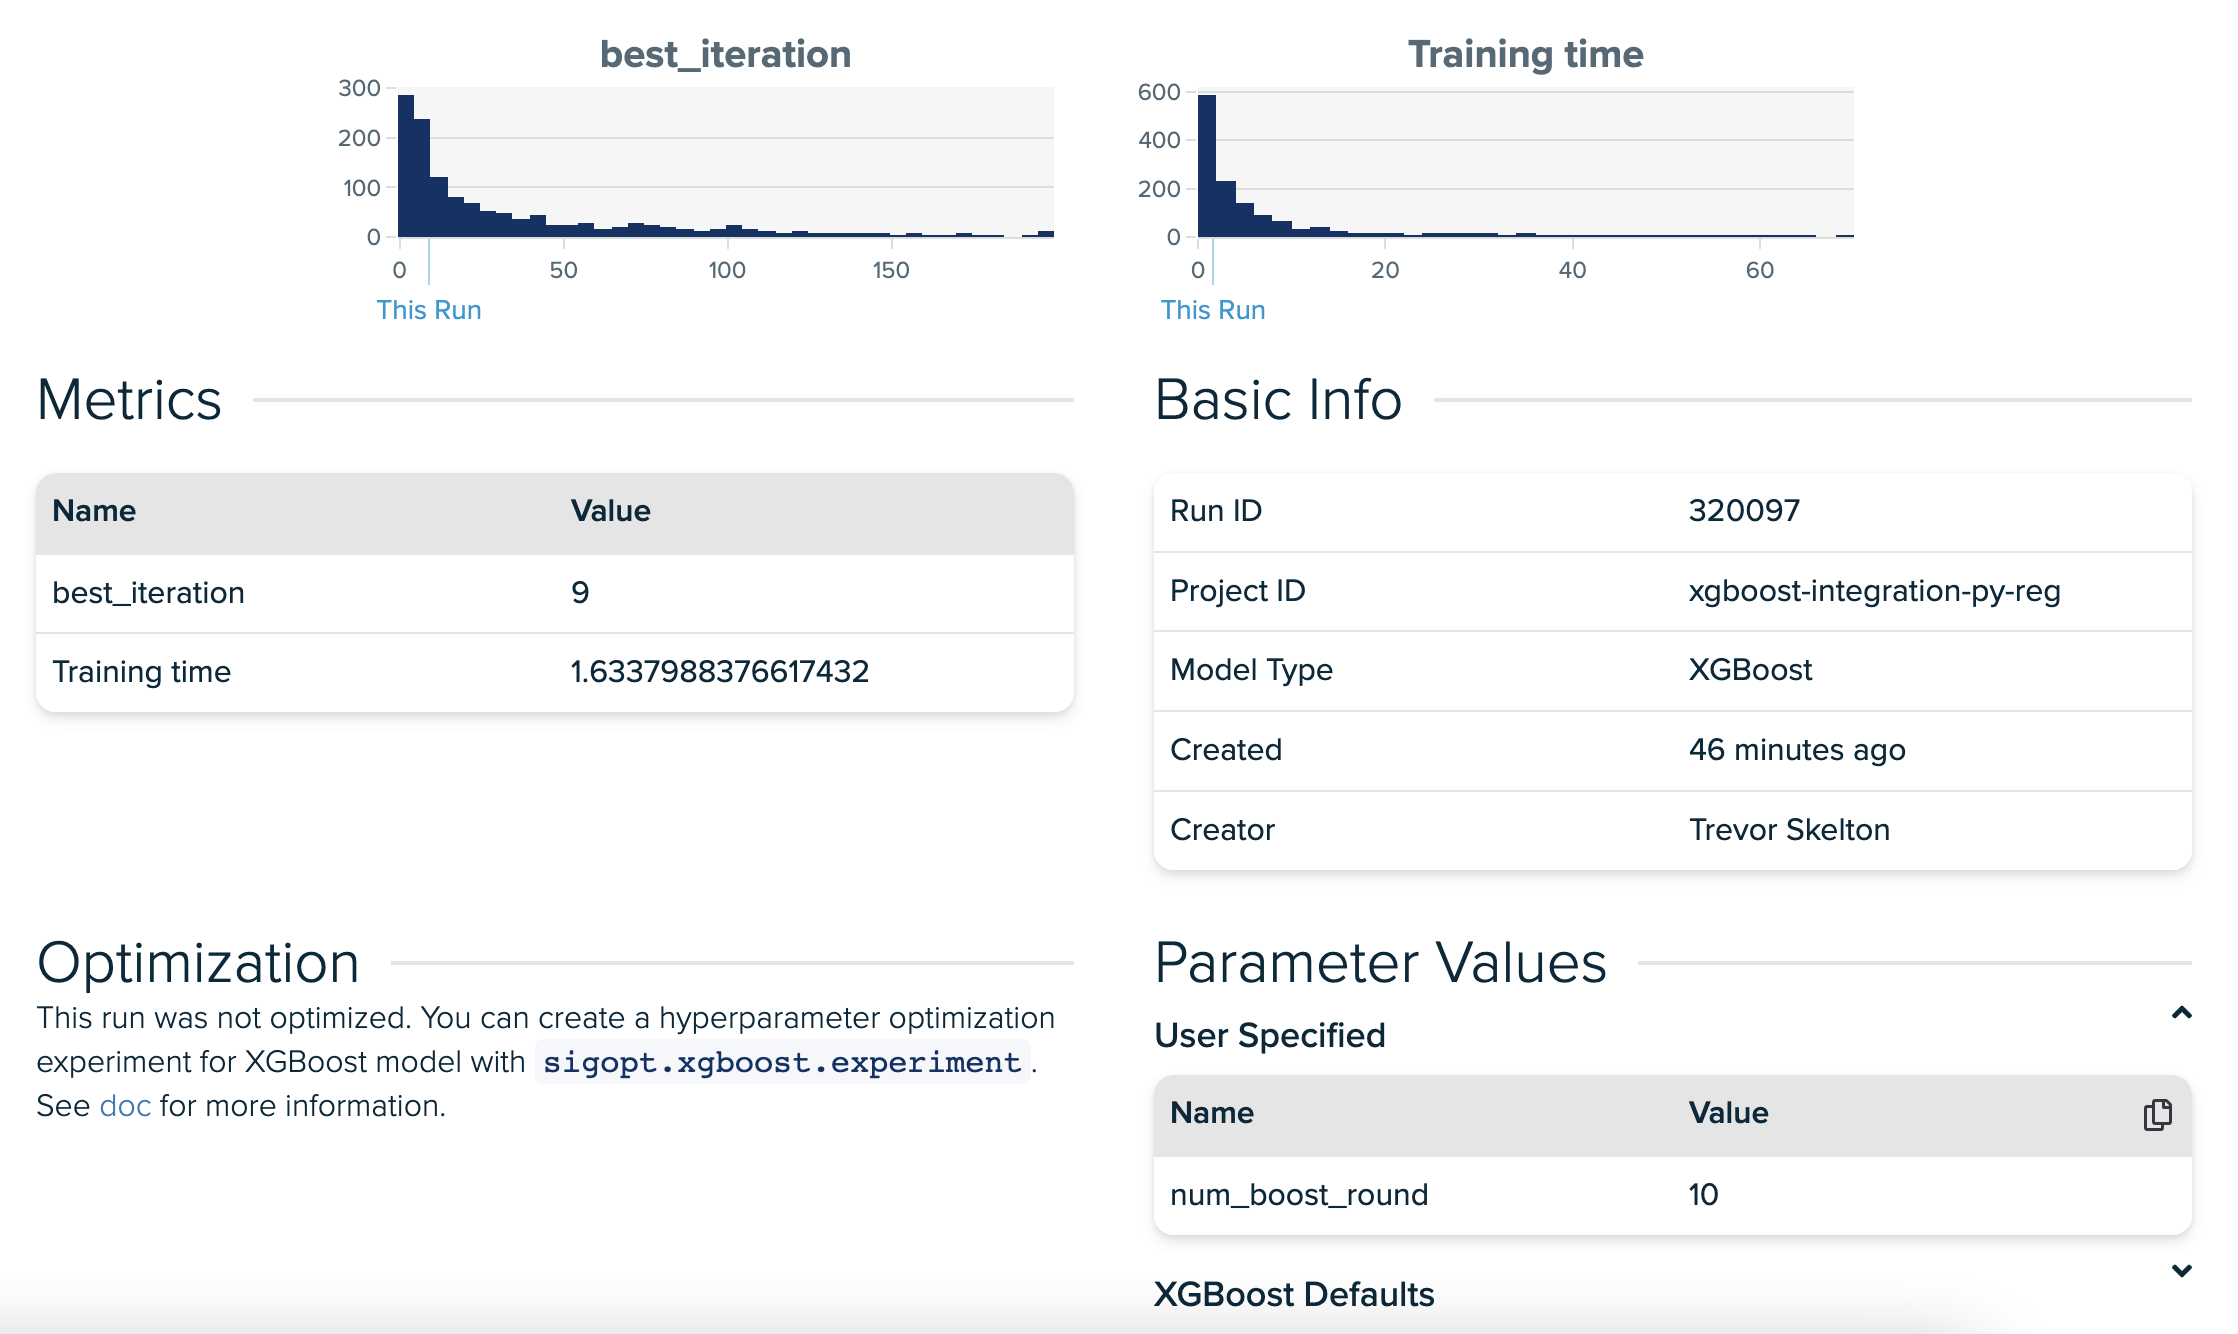

After the XGBoost model is trained, SigOpt evaluates the model's performance with a few common metrics on the provide `evals` datasets (the test set in our case) as lists the results under **Metrics**. We can also clearly see this run's hyperparameters used in the **Parameter Values** section, which match the static values we provided, while the rest are listed as "XGBoost Defaults" which could be expanded to see the detail by clicking the arrow.

SigOpt also provides a bar chart with the relative feature importances XGBoost calculated during the run, which can be very helpful insight for analysis or feature engineering.

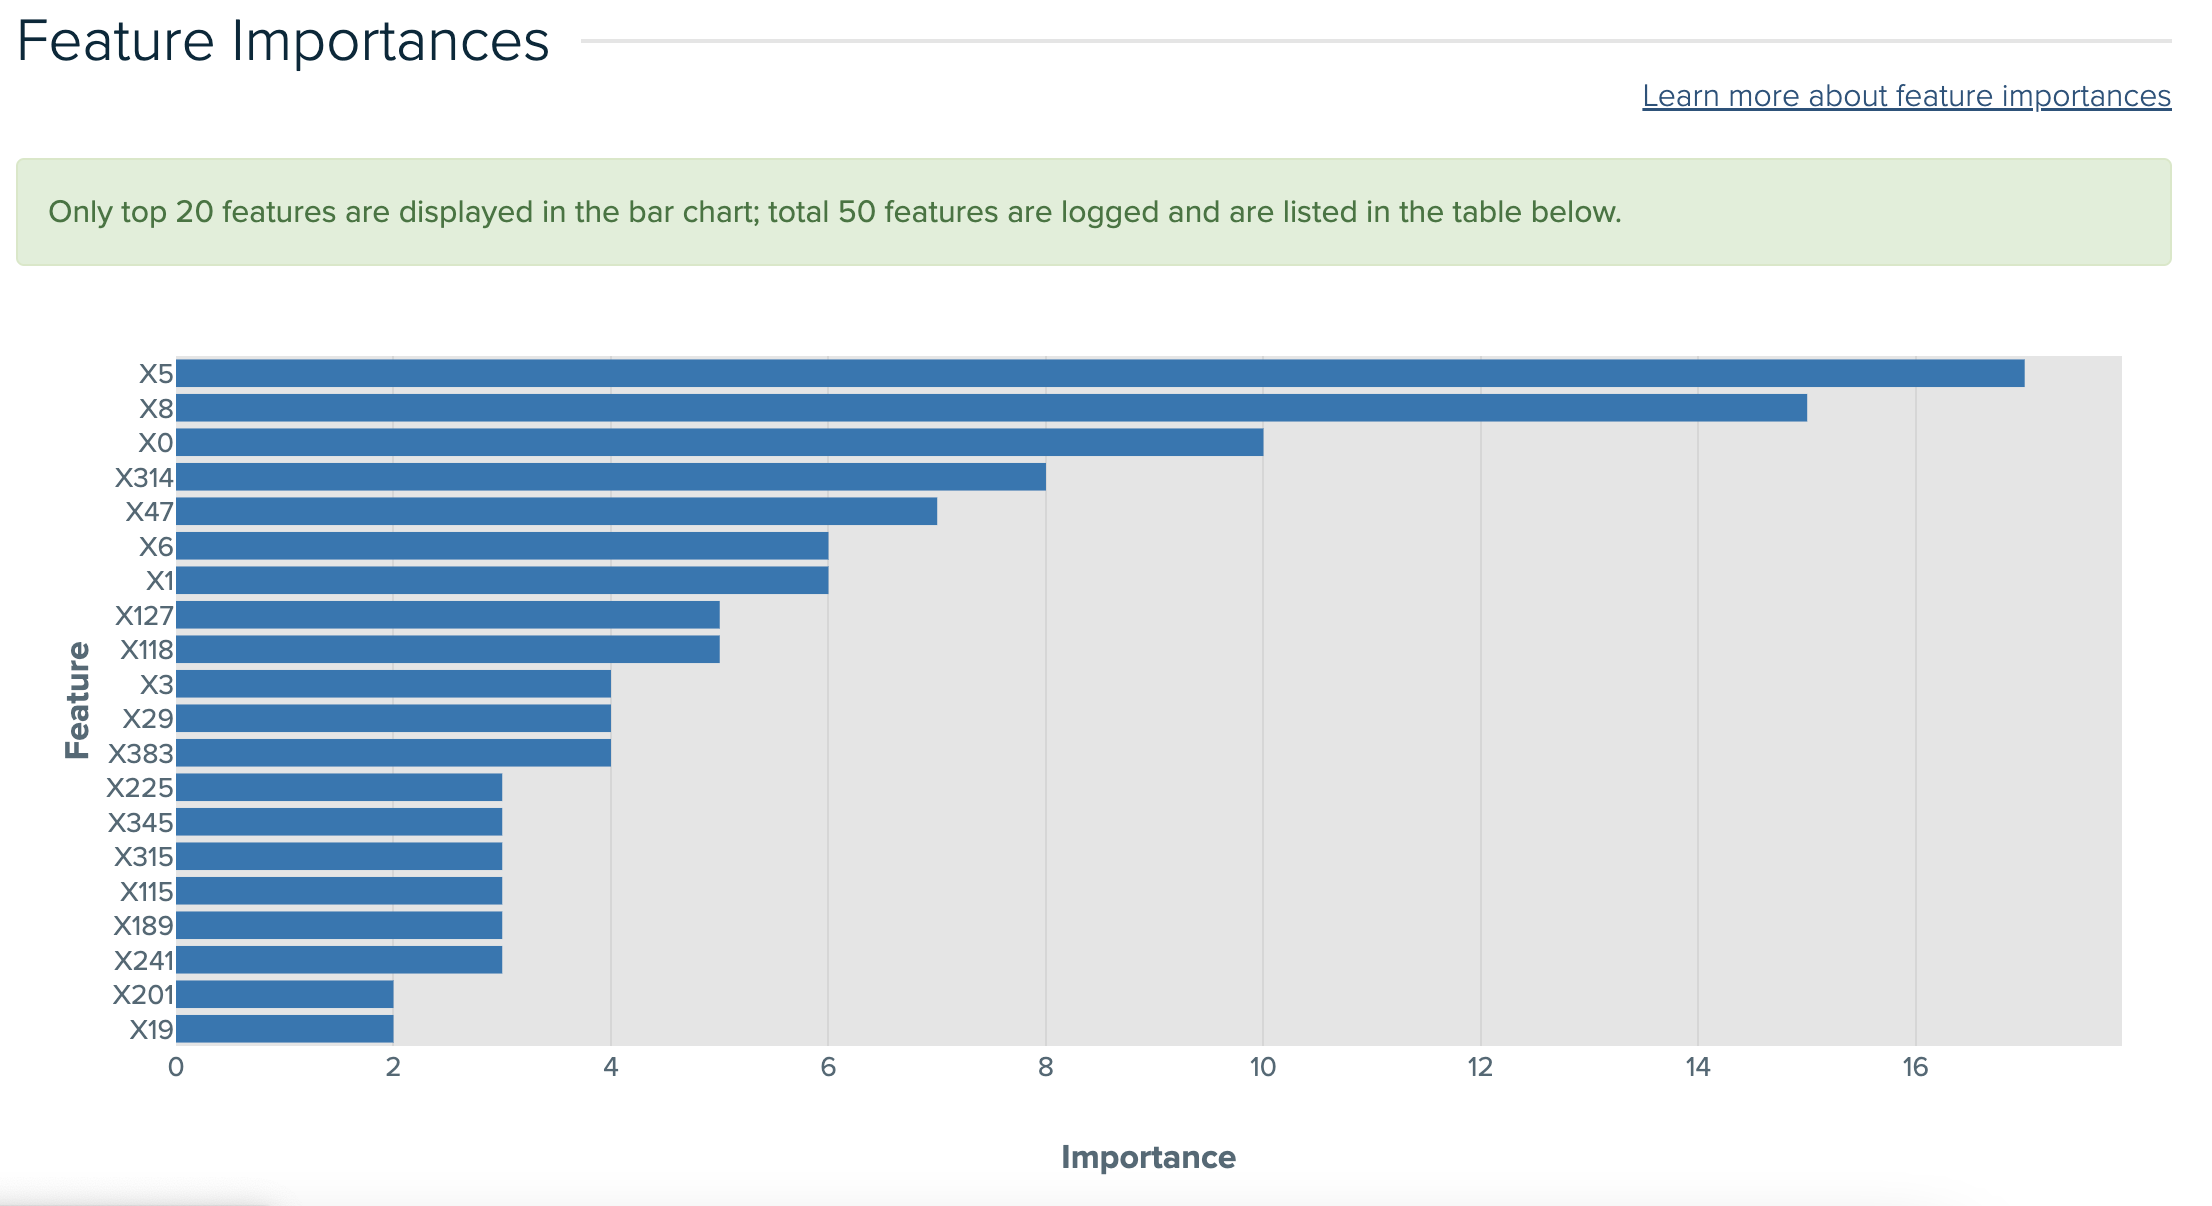

## Train and Tune SigOpt Model
In production and deployment of machine learning models, we seek to maximize our models' performance. SigOpt's experiment API allows for efficient, intelligent experimentation that will provide suggested hyperparameter values to enhance our models' performance with only a few lines of code. On top of this, using the XGBoost integration, we can take advantage of SigOpt's intelligent, automated hyperparameter selection. Often you need specialized expertise and techniques to find optimized hyperparameters, or even just to select the list of hyperparameters and bounds for other optimization packages. This integration removes this burden from the user, making high-performing XGBoost models much more accessible.

This is possible through extensive work by SigOpt's research team. The following violin plot shows the distribution of the importance scores measured by functional analysis of variance (FANOVA) over a suite of different learning problems and over 10,000 hyperparameter configurations of XGBoost, the results of which are used to inform the optimizer. Of course these orderings are not objective; they depend on the problem, optimization metric, etc. However, they form a reasonable foundation for SigOpt's optimizer in this integration. This is a small snippet of the results of the research into XGBoost that will be discussed further in the future.

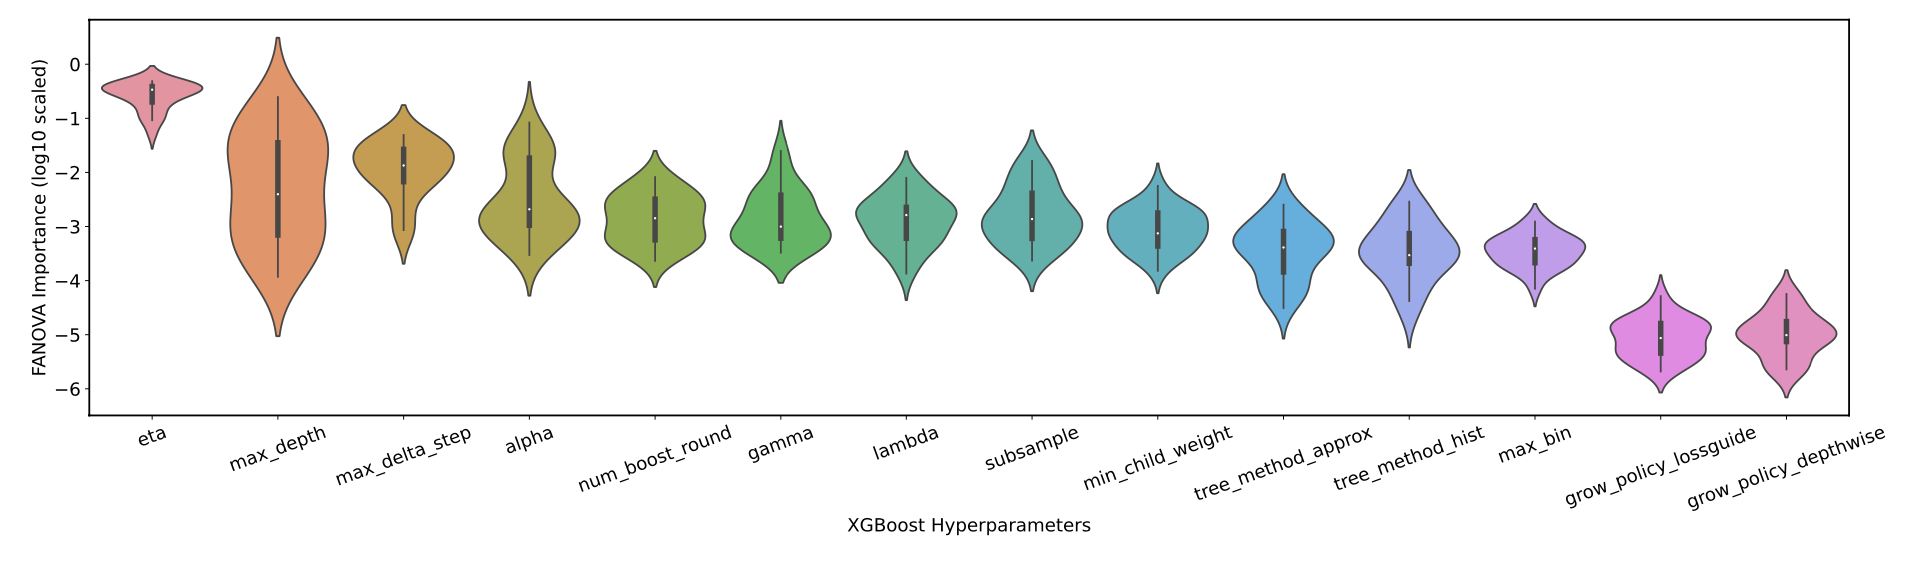

We'll first set the configuration for the experiment we will run. This includes the experiment name, metrics, and observation budget, or maximum number of runs SigOpt will perform. While we have the option to provide hyperparameter lists and bounds for the optimizer, in this example we'll omit these entirely and let the integration intelligently optimize the most important hyperparameters for us in an efficient manner. We therefore expect in our runs that the hyperparameters with most importance on the above plot such as `eta` (learning rate), `max_depth`, `alpha`, `num_boost_round`, and `gamma` to be of more focus for the SigOpt optimizer.

By default SigOpt uses the RMSE metric to optimize, which should work well for this kind of regression problem. Finally, we set our observation budget to 100 runs, which means we'll train 100 different models for SigOpt to optimize. Feel free to lower this for faster optimization at the cost of some performance, or increase this if you determine SigOpt can further optimize.

Our experiment configuration is set up simply with the following code block:

In [9]:
my_config = dict(
    name="XGBoost MB Test Time Predictor Experiment",
    budget=100,
)

We run an experiment by passing in the configuration and the matrices as seen below. SigOpt will optimize the hyperparameters against the performance on the validation set.

Here we also set a number of XGBoost model parameters to hold static for all experiment runs. This includes the objective (regression for this classification task), and verbosity to 0 to silence warnings being output to the notebook.

The below code block may take some time to complete depending on your system and the number of runs set (~30 minutes on a 4 core i5).

In [10]:
%%time
experiment = sigopt.xgboost.experiment(
    experiment_config=my_config,
    dtrain=dtrain,
    evals=[(dval, "val_set")],
    # XGB parameters to be fixed for all runs:
    params = {'objective':'reg:squarederror', "verbosity": 0}, 
)

Experiment created, view it on the SigOpt dashboard at https://app.sigopt.com/experiment/523351
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320098
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320098
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320099
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320099
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320100
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320100
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320101
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320101
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320102
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320102
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/3201

Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320149
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320150
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320150
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320151
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320151
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320152
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320152
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320153
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320153
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320154
Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320154
Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320155
Run finish

Run finished, view it on the SigOpt dashboard at https://app.sigopt.com/run/320202
CPU times: user 13min 7s, sys: 37 s, total: 13min 44s
Wall time: 27min 50s


After the above code block finishes, check the results of the experiment on your SigOpt [dashboard](https://app.sigopt.com/experiments), or dive into our SigOpt experiment results [here](https://app.sigopt.com/guest?guest_token=WAGLTJQMJVJIWORFEQCELTCVJHCJVEGKBLIBVBVLAGNGRPEZ) with a guest session. Explore the plots accessible for all SigOpt experiments, including experiment histories for the variation of each hyperparameter, parallel coordinates between hyperparameters, and the hyperparameter values for the best run. SigOpt also lists the relative **Parameter Importance** for each hyperparameter for the performance metric chosen. Under the History tab, you can also dive into any of the individual runs to check the Feature Importances or other metrics calculated for any particular training/optimization run.

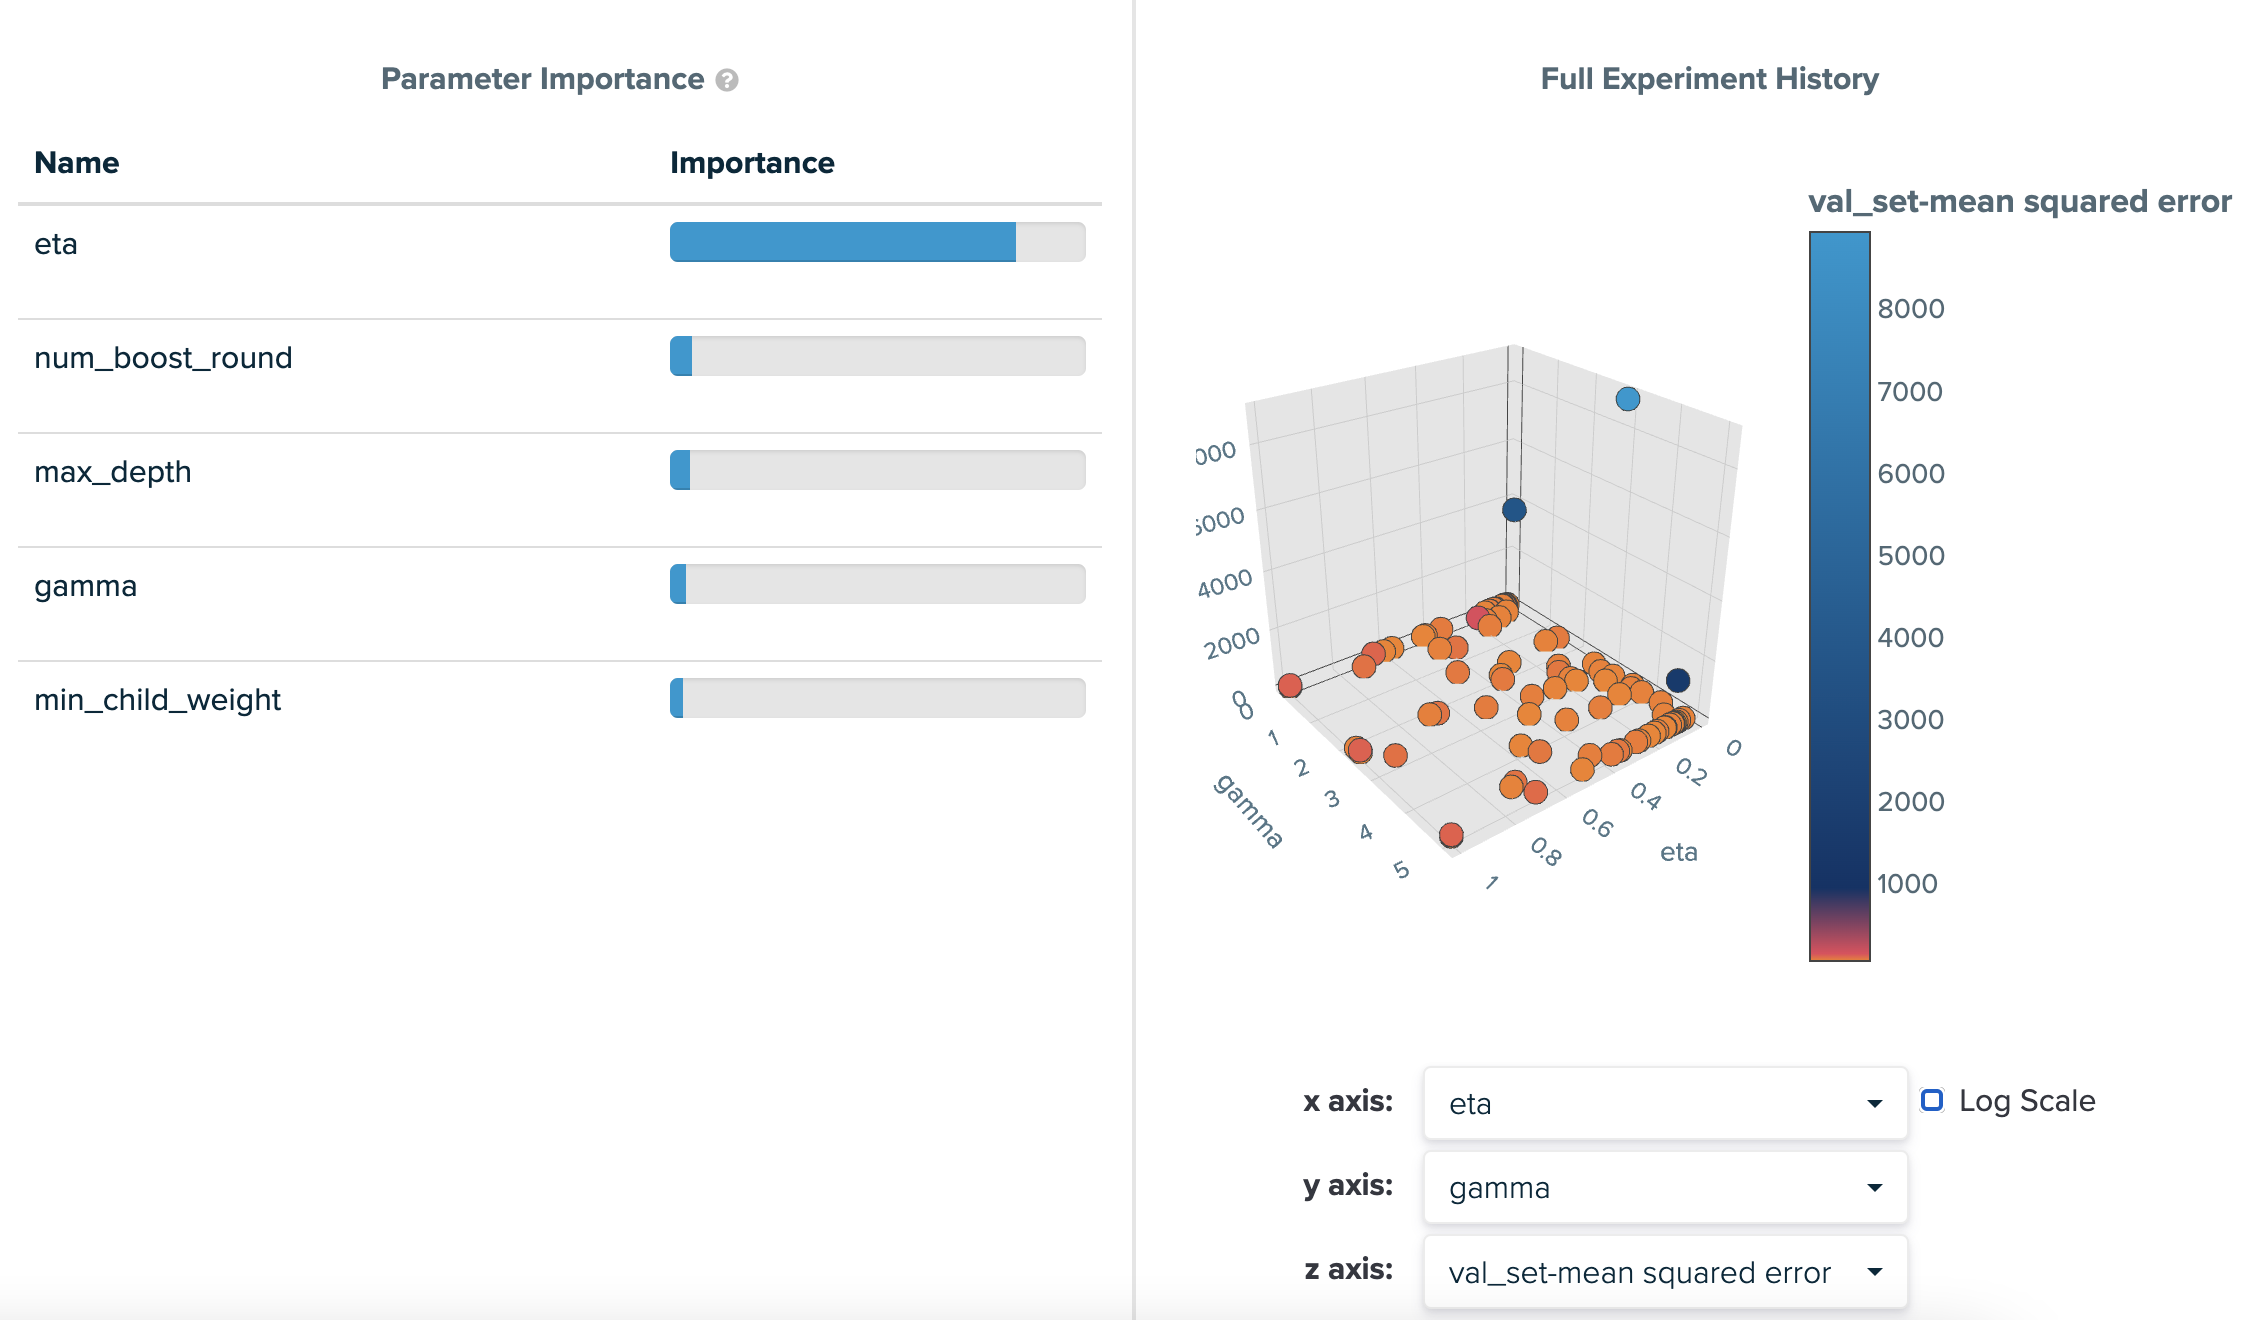

Based on SigOpt's provided Parameter Importance, by far the hyperparameter with the largest impact is the learning rate, `eta`, which is what we would expect based on the SigOpt research results. `num_boost_round` has an understandable significance, followed by `gamma`, `min_child_weight`, and `max_depth`.

Compared with the default hyperparameter values used in the baseline model, the SigOpt tuned model uses a smaller learning rate, higher regularization through `gamma` and `min_child_weight` to prune large trees, and a higher `max_depth` allowing trees to form higher complexity predictors. The deeper trees are likely needed given the high dimensionality of our data, while still serving as weak learners for boosting. The better regularization will hopefully allow the model to generalize better on unseen data, even though each individual tree can grow deeper.

## Evaluate on Test Set

Finally, we'll evaluate the baseline and SigOpt-tuned XGBoost models against the holdout test set to see how well they perform on data neither model has seen.

First, we'll take the hyperparameters from the best SigOpt training run during our experimentation and train a model with the training set. We can use `experiment.get_best_runs()` to return an iterator of the best runs, then take the `assignments` from the best run to use the hyperparameters used in SigOpt's best performing run. We also use the best assignments to retrieve the number of boosting rounds and early stopping rounds used for the best SigOpt run, and provide these as arguments to `sigopt.xgboost.run`.

In [11]:
%%time
for run in experiment.get_best_runs():
    sigopt_params = dict(run.assignments) #obtain best SigOpt run's parameter values

sigopt_run_options = { 'name':'SigOpt Optimized XGBoost MB Test Time Predictor' }
sigopt_fraud = sigopt.xgboost.run(sigopt_params,
                             dtrain,
                             num_boost_round=sigopt_params['num_boost_round'],
                             early_stopping_rounds=sigopt_params['early_stopping_rounds'],
                             evals=[(dval,'val_set')],
                             run_options=sigopt_run_options)
sigopt_model = sigopt_fraud.model
print(f"View run at https://app.sigopt.com/run/{sigopt_fraud.run.id}")

Run started, view it on the SigOpt dashboard at https://app.sigopt.com/run/320203
[0]	val_set-rmse:87.03078
[1]	val_set-rmse:75.42404
[2]	val_set-rmse:65.37766
[3]	val_set-rmse:56.69080
[4]	val_set-rmse:49.18534
[5]	val_set-rmse:42.70121
[6]	val_set-rmse:37.11200
[7]	val_set-rmse:32.29221
[8]	val_set-rmse:28.15488
[9]	val_set-rmse:24.60469
[10]	val_set-rmse:21.56325
[11]	val_set-rmse:18.97576
[12]	val_set-rmse:16.78753
[13]	val_set-rmse:14.94690
[14]	val_set-rmse:13.41605
[15]	val_set-rmse:12.14489
[16]	val_set-rmse:11.10133
[17]	val_set-rmse:10.26208
[18]	val_set-rmse:9.59275
[19]	val_set-rmse:9.06741
[20]	val_set-rmse:8.64279
[21]	val_set-rmse:8.32665
[22]	val_set-rmse:8.07746
[23]	val_set-rmse:7.89234
[24]	val_set-rmse:7.75275
[25]	val_set-rmse:7.65676
[26]	val_set-rmse:7.57314
[27]	val_set-rmse:7.51550
[28]	val_set-rmse:7.47893
[29]	val_set-rmse:7.45331
[30]	val_set-rmse:7.42566
[31]	val_set-rmse:7.41048
[32]	val_set-rmse:7.40540
[33]	val_set-rmse:7.39482
[34]	val_set-rmse:7.38607


Now we can compare the baseline model versus the model tuned with SigOpt's XGBoost integration.

In [12]:
baseline_preds = baseline_model.predict(dtest)
sigopt_preds = sigopt_model.predict(dtest)

baseline_rmse = mean_squared_error(y_test, baseline_preds, squared=False)
sigopt_rmse = mean_squared_error(y_test, sigopt_preds, squared=False)

print(f'Baseline Test Set RMSE: {baseline_rmse}\nSigOpt Test Set RMSE: {sigopt_rmse}')

Baseline Test Set RMSE: 8.699273171530333
SigOpt Test Set RMSE: 7.965398692836245


With an identical model architecture, using SigOpt's XGBoost integration with intelligent selection and tuning of hyperparameters alone gives us a substantial boost in model performance for the metric we optimized for on unseen data. The CPU time to achieve these results is also relatively low, especially compared to alternatives to find well-performing hyperparameters like grid search or trial and error.

## Wrapping Up
Here we've demonstrated the power of SigOpt and the XGBoost integration in a relatively quick and simple regression machine learning problem. Using SigOpt's XGBoost Integration allows for expert-level optimization without expert-level knowledge of XGBoost, and allows fast and efficient hyperparameter experimentation with a simple and easy API.

Now it's time to try your hand at modeling! Can you do better on this dataset with more SigOpt runs, architecture improvements, feature engineering, or other optimization?

Please feel free to send us feedback on your experience with the XGBoost Integration at the [SigOpt Community](https://community.sigopt.com/). You can sign up for SigOpt for free at https://sigopt.com/signup.

Want to learn more? Explore:
* [Tracking XGBoost Training](https://docs.sigopt.com/xgboost/xgboost_run)
* [Tuning XGBoost Models](https://docs.sigopt.com/xgboost/xgboost_experiment)
* [Live Now! New XGBoost Integration](https://sigopt.com/blog/live-now-new-xgboost-integration/)
* [SigOpt Experiment Results](https://app.sigopt.com/guest?guest_token=WAGLTJQMJVJIWORFEQCELTCVJHCJVEGKBLIBVBVLAGNGRPEZ) for this code
* [Sign up for free!](https://sigopt.com/signup)